#  Question 1

# Load Data

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import json
import zipfile
import requests
import joblib
import urllib.request
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import itertools  
%matplotlib inline  
from sklearn.model_selection import train_test_split  
from collections import Counter  
from imblearn import under_sampling, over_sampling  
from imblearn.over_sampling import SMOTE  
from sklearn.model_selection import KFold  
from sklearn.model_selection import GridSearchCV  
from sklearn.model_selection import RandomizedSearchCV  
from sklearn.model_selection import cross_val_score  
from imblearn.metrics import classification_report_imbalanced  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import (precision_score, recall_score, roc_auc_score, accuracy_score,  
                                  confusion_matrix, precision_recall_curve, roc_curve, brier_score_loss)  

In [ ]:
filename, headers = urllib.request.urlretrieve(url, filename='transactions.zip')

In [ ]:
zf = zipfile.ZipFile('transactions.zip', 'r')

In [ ]:
zipinfos = zf.infolist()

In [ ]:
df = zf.open(zipinfos[0].filename).read().splitlines()

In [ ]:
df = [json.loads(rows) for rows in df]

In [ ]:
df = pd.DataFrame(df)

### **Describe the structure of the data. Number of records and fields in each record¶**

In [ ]:
df.info(verbose=True)
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  object 
 1   customerId                786363 non-null  object 
 2   creditLimit               786363 non-null  float64
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

(786363, 29)

The dataset has 3 boolean fields , 4 floating fields and 22 objects. It has 29 fields and 786363 records.

## Summary statistics for numerical fields

In [ ]:
df[[ creditLimit , availableMoney ,  transactionAmount , currentBalance ]].describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


### Names of merchants

In [ ]:
df.merchantName.unique()

array(['Uber', 'AMC #191138', 'Play Store', ..., 'ATT #141119',
       'EZ Wireless #200746', 'Runners #747070'], dtype=object)

### Number of merchants

In [ ]:
df.merchantName.value_counts()

Uber                             25613
Lyft                             25523
oldnavy.com                      16992
staples.com                      16980
alibaba.com                      16959
                                 ...  
Runners #383214                      2
Sprint Communications #561941        2
TMobile Wireless #602341             1
Curves #849125                       1
EZ Wireless #149871                  1
Name: merchantName, Length: 2490, dtype: int64

There are 2490 merchants.

### Countries cards were swiped at

In [ ]:
df.acqCountry.unique()

array(['US', '', 'CAN', 'MEX', 'PR'], dtype=object)

In [ ]:
df.replace('', np.nan, inplace=True)

### Names of merchants

In [ ]:
df.merchantCategoryCode.unique()

array(['rideshare', 'entertainment', 'mobileapps', 'fastfood',
       'food_delivery', 'auto', 'online_retail', 'gym', 'health',
       'personal care', 'food', 'fuel', 'online_subscriptions',
       'online_gifts', 'hotels', 'airline', 'furniture', 'subscriptions',
       'cable/phone'], dtype=object)

### Categories of merchants

In [ ]:
df.merchantCategoryCode.unique()

array(['rideshare', 'entertainment', 'mobileapps', 'fastfood',
       'food_delivery', 'auto', 'online_retail', 'gym', 'health',
       'personal care', 'food', 'fuel', 'online_subscriptions',
       'online_gifts', 'hotels', 'airline', 'furniture', 'subscriptions',
       'cable/phone'], dtype=object)

## Question 2: Plot 

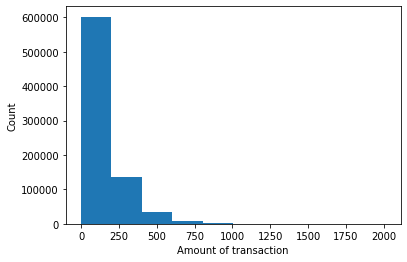

In [ ]:
plt.hist(df['transactionAmount'])
plt.xlabel('Amount of transaction')
plt.ylabel('Count')
plt.show()

We can see that most transactions are between 0 and 250. However, to see a more detailed distribution we will remove the outliers.

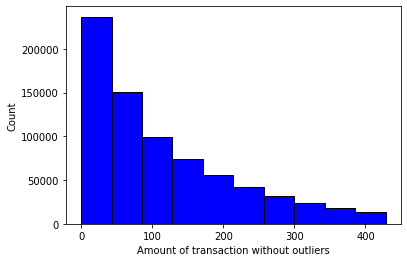

In [ ]:
q1, q3 = np.percentile(sorted(df.transactionAmount),[25,75])
iqr = q3 - q1
lower_bound = 0
upper_bound = q3 + (1.5 * iqr)
x = df.transactionAmount[df.transactionAmount.between(lower_bound, upper_bound)]
plt.hist(x, color='blue', edgecolor='black')
plt.xlabel('Amount of transaction without outliers')
plt.ylabel('Count')
plt.show()

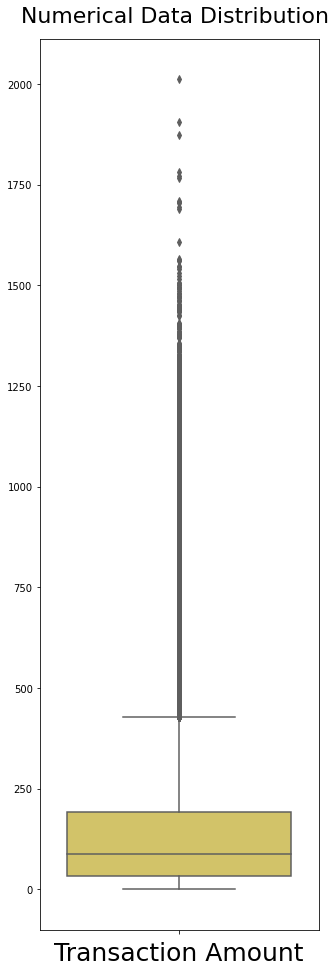

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,15))
sns.boxplot(data=df, y='transactionAmount', color='#E3CF57', orient='v')
ax.set_xlabel('Transaction Amount', fontsize=25)
ax.set_ylabel('')
fig.suptitle('Numerical Data Distribution', fontsize=22)
fig.subplots_adjust(top=0.95)

We can see that the distribution of transaction amount is heavily right skewed. We can hypothesize that most valid transactions are between 0 and 250 and most transactions are under 100.



## Question 3: Data Wrangling

In [ ]:
# Converting time to standard format 
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'], infer_datetime_format=True)
df['currentExpDate'] = pd.to_datetime(df['currentExpDate'], infer_datetime_format=True)
df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'], infer_datetime_format=True)
df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'], infer_datetime_format=True)

Reversed Transactions

In [ ]:
duplicated = df[df.duplicated(['accountNumber', 'customerId', 'transactionAmount', 'merchantName'], keep=False)]

In [ ]:
duplicatePurchase = duplicated[duplicated.transactionType == 'PURCHASE']

In [ ]:
duplicateReversal = duplicated[duplicated.transactionType == 'REVERSAL']

In [ ]:
reversedTrans = pd.merge(duplicatePurchase, duplicateReversal, on=['accountNumber', 'customerId', 'transactionAmount', 'merchantName'], how='inner')

In [ ]:
#Records where purchasing transaction DateTime is earlier than its reversal transaction DateTime
reversedTrans = reversedTrans[reversedTrans.transactionDateTime_x < reversedTrans.transactionDateTime_y]

In [ ]:
#Reversed Transactions
reversedTrans.head()

,accountNumber,customerId,creditLimit_x,availableMoney_x,transactionDateTime_x,transactionAmount,merchantName,acqCountry_x,merchantCountryCode_x,posEntryMode_x,posConditionCode_x,merchantCategoryCode_x,currentExpDate_x,accountOpenDate_x,dateOfLastAddressChange_x,cardCVV_x,enteredCVV_x,cardLast4Digits_x,transactionType_x,echoBuffer_x,currentBalance_x,merchantCity_x,merchantState_x,merchantZip_x,cardPresent_x,posOnPremises_x,recurringAuthInd_x,expirationDateKeyInMatch_x,isFraud_x,creditLimit_y,availableMoney_y,transactionDateTime_y,acqCountry_y,merchantCountryCode_y,posEntryMode_y,posConditionCode_y,merchantCategoryCode_y,currentExpDate_y,accountOpenDate_y,dateOfLastAddressChange_y,cardCVV_y,enteredCVV_y,cardLast4Digits_y,transactionType_y,echoBuffer_y,currentBalance_y,merchantCity_y,merchantState_y,merchantZip_y,cardPresent_y,posOnPremises_y,recurringAuthInd_y,expirationDateKeyInMatch_y,isFraud_y
0,574788567,574788567,2500.0,2416.11,2016-05-24 01:35:33,215.13,Convenient Tire,US,US,09,01,auto,2021-10-01,2015-10-13,2015-10-13,206,206,8522,PURCHASE,NaN,83.89,NaN,NaN,NaN,True,NaN,NaN,False,False,2500.0,2200.98,2016-05-24 01:38:03,US,US,09,01,auto,2021-10-01,2015-10-13,2015-10-13,206,206,8522,REVERSAL,NaN,299.02,NaN,NaN,NaN,True,NaN,NaN,False,False
1,924729945,924729945,50000.0,50000.00,2016-10-04 04:20:04,168.57,discount.com,US,US,05,01,online_retail,2024-11-01,2014-07-25,2014-07-25,205,265,9459,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False,50000.0,49831.43,2016-10-19 14:01:45,US,US,05,01,online_retail,2024-11-01,2014-07-25,2014-07-25,205,265,9459,REVERSAL,NaN,168.57,NaN,NaN,NaN,False,NaN,NaN,False,False
2,984504651,984504651,50000.0,49138.85,2016-01-06 04:08:06,83.64,1st Sandwitch Bar #801388,US,US,09,01,food,2025-11-01,2015-07-27,2015-07-27,640,640,8332,PURCHASE,NaN,861.15,NaN,NaN,NaN,True,NaN,NaN,False,False,50000.0,38090.70,2016-02-04 00:14:42,US,US,09,01,food,2025-11-01,2015-07-27,2015-07-27,640,640,8332,REVERSAL,NaN,11909.30,NaN,NaN,NaN,True,NaN,NaN,False,False
3,984504651,984504651,50000.0,46818.15,2016-01-16 09:52:30,450.74,Planet Fitness #849960,US,US,05,01,health,2028-08-01,2015-07-27,2015-07-27,640,640,8332,PURCHASE,NaN,3181.85,NaN,NaN,NaN,False,NaN,NaN,False,False,50000.0,46367.41,2016-01-16 09:53:15,US,US,05,01,health,2028-08-01,2015-07-27,2015-07-27,640,640,8332,REVERSAL,NaN,3632.59,NaN,NaN,NaN,False,NaN,NaN,False,False
4,984504651,984504651,50000.0,46341.05,2016-01-17 08:13:08,81.73,AMC #724446,US,US,09,01,entertainment,2031-12-01,2015-07-27,2015-07-27,640,640,8332,PURCHASE,NaN,3658.95,NaN,NaN,NaN,True,NaN,NaN,False,False,50000.0,41909.30,2016-01-25 20:39:15,US,US,09,01,entertainment,2031-12-01,2015-07-27,2015-07-27,640,640,8332,REVERSAL,NaN,8090.70,NaN,NaN,NaN,True,NaN,NaN,False,False


In [ ]:
duplicatePurchase.sort_values(['accountNumber', 'customerId', 'merchantName', 'transactionDateTime'])

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
541963,100088067,100088067,50000.0,49834.20,2016-11-20 07:57:05,22.32,AMC #79863,US,US,09,01,entertainment,2020-06-01,2014-01-09,2014-01-09,546,546,4615,PURCHASE,NaN,165.80,NaN,NaN,NaN,True,NaN,NaN,False,False
541919,100088067,100088067,50000.0,50000.00,2016-05-05 22:47:50,3.96,Apple iTunes,US,US,09,01,mobileapps,2033-07-01,2014-01-09,2014-01-09,546,546,4615,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
541926,100088067,100088067,50000.0,49695.85,2016-06-05 22:10:41,3.96,Apple iTunes,US,US,09,01,mobileapps,2033-07-01,2014-01-09,2014-01-09,546,546,4615,PURCHASE,NaN,304.15,NaN,NaN,NaN,False,NaN,NaN,False,False
541929,100088067,100088067,50000.0,50000.00,2016-07-05 22:22:49,3.96,Apple iTunes,US,US,09,01,mobileapps,2033-07-01,2014-01-09,2014-01-09,546,546,4615,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
541936,100088067,100088067,50000.0,50000.00,2016-08-05 00:55:48,3.96,Apple iTunes,US,US,09,01,mobileapps,2033-07-01,2014-01-09,2014-01-09,546,546,4615,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108110,999389635,999389635,5000.0,4900.94,2016-08-22 11:42:48,4.62,Play Store,US,US,05,01,mobileapps,2033-04-01,2015-10-09,2015-10-09,140,140,3991,PURCHASE,NaN,99.06,NaN,NaN,NaN,False,NaN,NaN,False,False
108112,999389635,999389635,5000.0,4653.70,2016-09-22 13:58:30,4.62,Play Store,US,US,05,01,mobileapps,2033-04-01,2015-10-09,2015-10-09,140,140,3991,PURCHASE,NaN,346.30,NaN,NaN,NaN,False,NaN,NaN,False,False
108113,999389635,999389635,5000.0,4674.08,2016-10-23 16:47:41,4.62,Play Store,US,US,05,01,mobileapps,2033-04-01,2015-10-09,2015-10-09,140,140,3991,PURCHASE,NaN,325.92,NaN,NaN,NaN,False,NaN,NaN,False,False
108114,999389635,999389635,5000.0,4694.46,2016-11-24 00:21:46,4.62,Play Store,US,US,05,01,mobileapps,2033-04-01,2015-10-09,2015-10-09,140,140,3991,PURCHASE,NaN,305.54,NaN,NaN,NaN,False,NaN,NaN,False,False


In [ ]:
def span(df):
    df['time_span'] = df[ transactionDateTime ].diff(1).dt.total_seconds() / 3600
    return df

In [ ]:
multipurchase = duplicatePurchase.groupby(['accountNumber', 'customerId', 'merchantName', 'transactionAmount']).apply(span)

In [ ]:
#Records with transaction time span less than an hour
multi_swipe = multipurchase[multipurchase.time_span < 1]

Total number of transactions and total dollar amount estimated for the reversed transactions and the multi-swipe transactions

In [ ]:
print(f The total number of transactions for reversed transactions is {reversedTrans.shape[0]}. )
print(f The total dollar estimated  for reversed transactions is {reversedTrans.transactionAmount.sum()}. )
print(f The total number of multi-swipe transactions is {multi_swipe.shape[0]}. )
print(f The total dollar estimated  for reversed transactions is {multi_swipe.transactionAmount.sum()} )

The total number of transactions for reversed transactions is 17999.
The total dollar estimated  for reversed transactions is 2701311.87.
The total number of multi-swipe transactions is 7450.
The total dollar estimated  for reversed transactions is 1103132.25


### Analysis of transactions

We want to observe if there is any pattern between the type of merchant and the probability of having duplicate transactions.

In [ ]:
all_pro = df.merchantCategoryCode.value_counts(normalize=True).rename_axis('MerchantCategory').to_frame('overall_proportion')
rev_pro = reversedTrans.merchantCategoryCode_x.value_counts(normalize=True).rename_axis('MerchantCategory').to_frame('reversed_proportion')
mul_pro = multi_swipe.merchantCategoryCode.value_counts(normalize=True).rename_axis('MerchantCategory').to_frame('multi_proportion')

In [ ]:
mer_pro = all_pro.merge(rev_pro, how='left', on=['MerchantCategory']).merge(mul_pro, how='left', on=['MerchantCategory'])
mer_pro

,overall_proportion,reversed_proportion,multi_proportion
MerchantCategory,,,
online_retail,0.257077,0.275460,0.275705
fastfood,0.142603,0.155620,0.160000
entertainment,0.101859,0.108950,0.115302
food,0.095999,0.104784,0.103221
online_gifts,0.084233,0.095116,0.089799
rideshare,0.065028,0.067782,0.068456
hotels,0.043360,0.049725,0.045235
fuel,0.030406,NaN,NaN
subscriptions,0.029123,0.030502,0.031141


From the dataset above, we can see that merchants with a high percentage of the total transaction are usually more likely to have canceled the transaction or multi-swipe transaction. It also means that most traders do not have much higher or lower options for performing reverse or multi-swipe transactions. However, for fuel dealers, there are no records in the However, for fuel dealers, there are no records in the canceled and multi-swipe transaction data, which make up more than 3% of the total transaction data. This means that fuel traders have little opportunity to offer their clients reverse or multi-swipe transactions.

We will now try to observe the time lapse between duplicate transactions.

In [ ]:
#Time span of reversed transactions 
reversedTrans['time_span'] = ((reversedTrans.transactionDateTime_y - reversedTrans.transactionDateTime_x) / np.timedelta64(1, 'D')).astype(int)

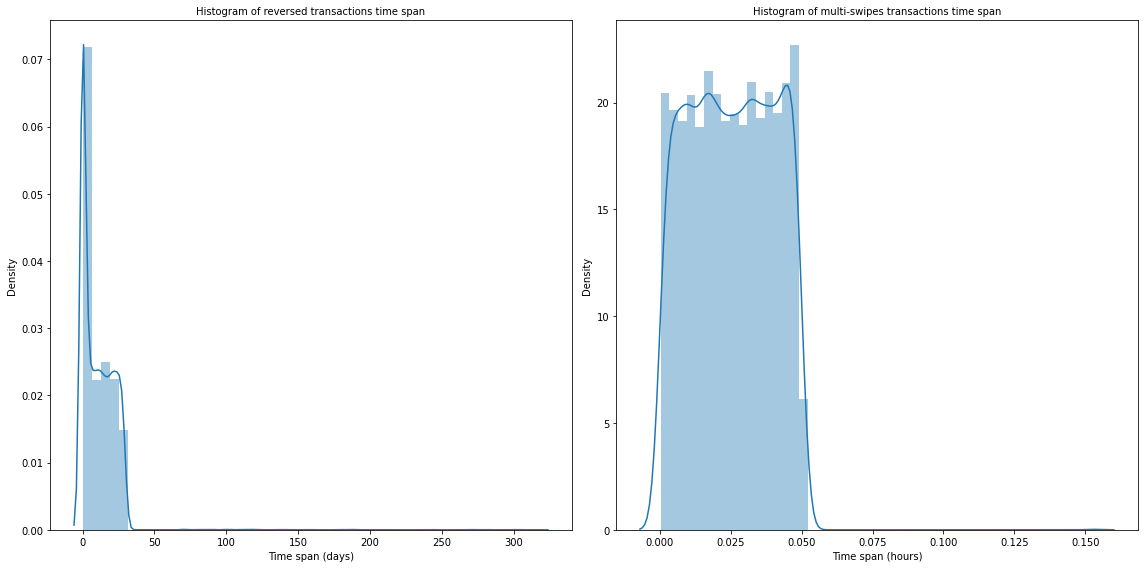

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.distplot(reversedTrans.time_span, hist=True, kde=True, ax=ax[0])
ax[0].set_xlabel('Time span (days)')
ax[0].set_title('Histogram of reversed transactions time span', fontsize=10)
# A KDE plot of transactions without outliers
sns.distplot(multi_swipe.time_span, hist=True, kde=True, ax=ax[1])
ax[1].set_xlabel('Time span (hours)')
ax[1].set_title('Histogram of multi-swipes transactions time span', fontsize=10)
plt.tight_layout()
plt.show()

From the figure above, we can see that there are many days between some canceled transactions. And almost all of them happen within 50 days. Multi-swipe transactions often occur within seconds. Almost all of them occur within 3 minutes.

## Question 4: Modeling 

### Pre-processing

In [ ]:
df1 = df.copy()

In [ ]:
#Drop columns with no records
df1 = df1.drop(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], axis=1)

In [ ]:
# Inspect missing values columns
missingValueColumns = df1.columns[df1.isnull().any()].tolist()
percent_missing = df1[missingValueColumns].isnull().sum() / len(df1)

In [ ]:
print(percent_missing)

acqCountry             0.005801
merchantCountryCode    0.000921
posEntryMode           0.005155
posConditionCode       0.000520
transactionType        0.000888
dtype: float64


Since the percentage of missing values is really low, instead of dropping the columns, we can impute the values

In [ ]:
# Inspecting missing values columns
print("Frequency of values in column acqCountry: \n",df1.acqCountry.value_counts())
print("Frequency of values in column merchantCountryCode: \n",df1.merchantCountryCode.value_counts())
print("Frequency of values in column posEntryMode: \n",df1.posEntryMode.value_counts())
print("Frequency of values in column posConditionCode: \n",df1.posConditionCode.value_counts())
print("Frequency of values in column transactionType: \n",df1.transactionType.value_counts())

Frequency of values in column acqCountry: 
 US     774709
MEX      3130
CAN      2424
PR       1538
Name: acqCountry, dtype: int64
Frequency of values in column merchantCountryCode: 
 US     778511
MEX      3143
CAN      2426
PR       1559
Name: merchantCountryCode, dtype: int64
Frequency of values in column posEntryMode: 
 05    315035
09    236481
02    195934
90     19576
80     15283
Name: posEntryMode, dtype: int64
Frequency of values in column posConditionCode: 
 01    628787
08    149634
99      7533
Name: posConditionCode, dtype: int64
Frequency of values in column transactionType: 
 PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Name: transactionType, dtype: int64


We can see that all 5 columns are skewed to one category. So, we can use their respective modes to impute the missing values.

In [ ]:
df1['acqCountry'] = df1['acqCountry'].fillna(df1['acqCountry'].mode()[0])
df1['merchantCountryCode'] = df1['merchantCountryCode'].fillna(df1['merchantCountryCode'].mode()[0])
df1['posEntryMode'] = df1['posEntryMode'].fillna(df1['posEntryMode'].mode()[0])
df1['posConditionCode'] = df1['posConditionCode'].fillna(df1['posConditionCode'].mode()[0])
df1['transactionType'] = df1['transactionType'].fillna(df1['transactionType'].mode()[0])

### Feature Engineering

We will squeeze the columns that do not provide additional information into one column

In [ ]:
# Convert cardCVV and enteredCVV to rightCVV
df1['rightCVV'] = (df1.cardCVV == df1.enteredCVV).astype(int)
df1 = df1.drop(['cardCVV', 'enteredCVV'], axis=1)

In [ ]:
# Convert acqCountry and merchantCountryCode to sameCountry
df1['sameCountry'] = (df1.acqCountry == df1.merchantCountryCode).astype(int)
df1 = df1.drop(['acqCountry', 'merchantCountryCode'], axis=1)

In [ ]:
# Convert merchantName to first purchase
df1 = df1.sort_values(['customerId', 'merchantName', 'transactionDateTime'])
df1['firPurchase'] = df1.groupby(['customerId', 'merchantName']).cumcount()
df1['firPurchase'][df1['firPurchase'] == 0] = 1
df1['firPurchase'][df1['firPurchase'] > 0] = 0

In [ ]:
# Convert datetime to time span (days)
df1['expTime'] = ((df1.currentExpDate - df1.transactionDateTime) / np.timedelta64(1, 'D'))
df1['openTime'] = ((df1.transactionDateTime - df1.accountOpenDate) / np.timedelta64(1, 'D'))
df1['changeAddTime'] = ((df1.transactionDateTime - df1.dateOfLastAddressChange) / np.timedelta64(1, 'D'))

The original record contains multiple dates, TransactionDateTime, currentExpDate, accountOpenDate, and dateOfLastAddressChange. I have converted these date and time features into more useful time interval features. For currentExpDate, change to expTime, which is the time between the transaction date and the expiration date. For accountOpenDate, change to openTime, which is the time between the account opening date and the transaction date. For dateOfLastAddressChange, change to changeAddTime, which is the time between the last address change date

In [ ]:
lst_re = ['accountNumber', 'transactionAmount', 'merchantName', 'transactionDateTime_y', 'transactionType_y']
lst_or = ['accountNumber', 'transactionAmount', 'merchantName', 'transactionDateTime', 'transactionType']
df1.loc[df1.set_index(lst_or).index.isin(reversedTrans.set_index(lst_re).index) == True, 'reversed'] = 1

In [ ]:
df1.reversed = df1.reversed.fillna(0)

In [ ]:
# Check number of reversed transactions and other transactions
df1.reversed.value_counts()

0.0    768604
1.0     17759
Name: reversed, dtype: int64

In [ ]:
lst_mul = ['accountNumber', 'transactionAmount', 'merchantName', 'transactionDateTime', 'transactionType']
lst_or = ['accountNumber', 'transactionAmount', 'merchantName', 'transactionDateTime', 'transactionType']
df1.loc[df.set_index(lst_or).index.isin(multi_swipe.set_index(lst_mul).index) == True, 'multi'] = 1

In [ ]:
# if not multi-swipe transaction, multi = 0
df1.multi = df1.multi.fillna(0)

In [ ]:
# Check the number of multi-swipe transactions
df1.multi.value_counts()

0.0    778913
1.0      7450
Name: multi, dtype: int64

In [ ]:
#I have dropped columns which will not contribute in modeling and contain redundant information and are highly correlated with other fields
df1 = df1.drop(['accountNumber', 'customerId', 'cardLast4Digits', 'merchantName', 'transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'availableMoney'], axis=1)

In [ ]:
corr_matrix = df1.corr().abs()
correlation = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
correlation

,creditLimit,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,rightCVV,sameCountry,firPurchase,expTime,openTime,changeAddTime,reversed,multi
creditLimit,NaN,0.005581,0.653652,0.003929,0.002391,0.003108,0.001343,0.000435,NaN,0.001460,0.061550,0.062469,0.001585,0.001490
transactionAmount,NaN,NaN,0.023905,0.037361,0.001751,0.075651,0.000701,0.002096,NaN,0.002073,0.007879,0.028430,0.013546,0.000180
currentBalance,NaN,NaN,NaN,0.010529,0.001285,0.007715,0.003221,0.001113,NaN,0.004031,0.081993,0.169767,0.007321,0.002807
cardPresent,NaN,NaN,NaN,NaN,0.040393,0.043418,0.002988,0.000816,NaN,0.000097,0.020536,0.013711,0.005678,0.001190
expirationDateKeyInMatch,NaN,NaN,NaN,NaN,NaN,0.000972,0.000113,0.000419,NaN,0.000886,0.001220,0.001014,0.002953,0.000403
isFraud,NaN,NaN,NaN,NaN,NaN,NaN,0.010006,0.000570,NaN,0.001772,0.005899,0.005933,0.001550,0.000804
rightCVV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001091,NaN,0.001445,0.000047,0.001246,0.000767,0.000215
sameCountry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001238,0.000514,0.000833,0.001229,0.001125
firPurchase,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expTime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013492,0.003807,0.000334,0.000384


The highest correlation is 0.65. So we don't need to drop anymore columns.

In [ ]:
# Convert categorical features into dummy variables
cat = df1.select_dtypes(include=['object']).columns.to_list()
df1 = pd.get_dummies(df1, cat, drop_first=True)

In [ ]:
# Convert boolean features into int variables
boo = df1.select_dtypes(include=['bool']).columns.to_list()
for column in boo:
    df1[column] = df1[column].astype(int)
    df1.reversed = df1.reversed.astype(int)
    df1.multi = df1.multi.astype(int)

Text(0, 0.5, 'Number of class labels')

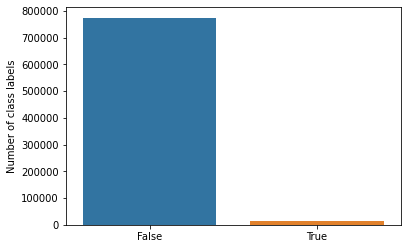

In [ ]:
fraud_vals = df1['isFraud'].value_counts()

sns.barplot(x=[0,1], y=fraud_vals)
plt.xticks(ticks=[0,1], labels=['False', 'True'])
plt.ylabel('Number of class labels')

Machine Learning algorithms perform poorly on highly imbalanced dataset such as the one we have. Multiple techniques have been developed to mitigate this problem. Undersampling and oversampling are two of the most popular approaches. In undersampling, we randomly sample from the majority class the number of data points equal to that of the minority class. This creates a balanced dataset but loses on vital information from the majority class data that was not selected.

Oversampling on the other hand uses methods to either resample the minority data points or generate new minority data points. SMOTE synthesises new minority instances between existing minority instances. Figuratively, it can be assumed that SMOTE draws lines between existing minority instances. It then interpolates the real minority instances along these lines to generate new data points.

In [ ]:
X = df1.drop(['isFraud'], axis = 1)
y = df1[['isFraud']]
sm = SMOTE(random_state=4)
X_smote, y_smote = SMOTE().fit_resample(X, y)
print( Original data distribution:  )
print(y.isFraud.value_counts())
print( SMOTE data distribution:  )
print(y_smote.isFraud.value_counts())

Original data distribution: 
0    773946
1     12417
Name: isFraud, dtype: int64
SMOTE data distribution: 
1    773946
0    773946
Name: isFraud, dtype: int64


### Model Building


Decision Tree: Decision trees create classification or regression models in the form of a tree structure. As the dataset is divided into smaller and smaller subsets, the relevant decision trees are developed in stages. The end result is a tree with decision nodes and leaf nodes. The decision node has more than one branch. Leaf nodes represent classifications or decisions.

In [ ]:
def DT_pred(X, y):
    RSC = RandomizedSearchCV(estimator=DecisionTreeClassifier(), param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': range(1, 100, 10),
                                                                                      'max_features': ['auto', 'sqrt', 'log2']},cv=3, scoring='roc_auc', n_jobs=-1, verbose = True)
    search_result = RSC.fit(X, y)
    print( "Best using:"  , search_result.best_params_,  "Score:"  , search_result.best_score_)
    model_DT = DecisionTreeClassifier(criterion=search_result.best_params_[ "criterion" ],
           max_depth=search_result.best_params_[ "max_depth" ],
           max_features=search_result.best_params_[ "max_features" ])
       # Split dataset into 3 consecutive folds
    kf = KFold(n_splits=3, shuffle=True, random_state=None)
    i = 1
    for train, test in kf.split(X):  
          X_train = X.iloc[train,:]
          y_train = y.iloc[train,:]
          X_test = X.iloc[test]
          y_test = y.iloc[test]
          model_DT.fit(X_train, y_train)
          train_pred = model_DT.predict(X_train)
          y_pred = model_DT.predict(X_test)
          train_accuracy = accuracy_score(y_train, train_pred)
          train_precision = precision_score(y_train, train_pred)
          train_recall = recall_score(y_train, train_pred)
          train_auc = roc_auc_score(y_train, train_pred)
          test_accuracy = accuracy_score(y_test, y_pred)
          test_precision = precision_score(y_test, y_pred)
          test_recall = recall_score(y_test, y_pred)
          test_auc = roc_auc_score(y_test, y_pred)
          print('Fold '+ str(i), ':  Training accuracy: ', train_accuracy, 'Testing accuracy: ', test_accuracy)
          print('Fold '+ str(i), ':  Training precision: ', train_precision, 'Testing precision: ', test_precision)
          print('Fold '+ str(i), ':  Training recall: ', train_recall, 'Testing accuracy: ', test_recall)
          print('Fold '+ str(i), ':  Training auc: ', train_auc, 'Testing auc: ', test_auc)
          i += 1
    return model_DT

In [ ]:
model_DT = DT_pred(X_smote, y_smote)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best using: {'max_features': 'log2', 'max_depth': 31, 'criterion': 'entropy'} Score: 0.9430961827757115
Fold 1 :  Training accuracy:  0.9578749680210247 Testing accuracy:  0.934722189920227
Fold 1 :  Training precision:  0.9381447127059924 Testing precision:  0.9131884329661201
Fold 1 :  Training recall:  0.9803007081191192 Testing accuracy:  0.961067095815796
Fold 1 :  Training auc:  0.9578972861650897 Testing auc:  0.934669595882792
Fold 2 :  Training accuracy:  0.9615302618012109 Testing accuracy:  0.9363036956066703
Fold 2 :  Training precision:  0.9428659109296681 Testing precision:  0.9152422965984789
Fold 2 :  Training recall:  0.9825963076028492 Testing accuracy:  0.9616852891818883
Fold 2 :  Training auc:  0.9615318539930902 Testing auc:  0.936299858006311
Fold 3 :  Training accuracy:  0.9583788791466071 Testing accuracy:  0.9370285523796233
Fold 3 :  Training precision:  0.9396334523471341 Testing precision:  0.9166

Random Forests: It uses ensemble learning,  a technique that combines many classifiers to find a solution to a complex problem. The random forest algorithm consists of many decision trees. "Forests" created by  random forest algorithms are trained either through batch processing or bootstrap aggregation. Bagging is an ensemble meta-algorithm that improves the accuracy of machine learning algorithms. The algorithm sets the outcome based on the predictions of the decision tree. It makes predictions by taking the average or average of the outputs of various trees. Increasing the number of trees increases the accuracy of the results.

In [ ]:
def RF_pred(X, y):
    RSC = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions={'n_estimators': range(1, 200, 10),
    'max_depth': range(1, 100, 10), 'max_features': ['auto', 'sqrt', 'log2']}, cv=3, scoring='roc_auc', n_jobs=-1)
    search_result = RSC.fit(X, y)
    print( "Best using:"  , search_result.best_params_,  Score:  , search_result.best_score_)
    model_RF = RandomForestClassifier(n_estimators=search_result.best_params_[ "n_estimators" ], max_depth=search_result.best_params_[ "max_depth" ],
    max_features=search_result.best_params_[ "max_features" ])
    kf = KFold(n_splits=3, shuffle=True, random_state=None)
    i = 1
    for train, test in kf.split(X):
        X_train = X.iloc[train,:]
        y_train = y.iloc[train,:]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        model_RF.fit(X_train, y_train)
        train_pred = model_RF.predict(X_train)
        y_pred = model_RF.predict(X_test)
        train_accuracy = accuracy_score(y_train, train_pred)
        train_precision = precision_score(y_train, train_pred)
        train_recall = recall_score(y_train, train_pred)
        train_auc = roc_auc_score(y_train, train_pred)
        test_accuracy = accuracy_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred)
        test_recall = recall_score(y_test, y_pred)
        test_auc = roc_auc_score(y_test, y_pred)
        print('Fold '+ str(i), ':  Training accuracy: ', train_accuracy, 'Testing accuracy: ', test_accuracy)
        print('Fold '+ str(i), ':  Training precision: ', train_precision, 'Testing precision: ', test_precision)
        print('Fold '+ str(i), ':  Training recall: ', train_recall, 'Testing accuracy: ', test_recall)
        print('Fold '+ str(i), ':  Training auc: ', train_auc, 'Testing auc: ', test_auc)
        i += 1
    return model_RF

In [ ]:
model_RF = RF_pred(X_smote, y_smote)

Best using:  {'n_estimators': 161, 'max_features': 'sqrt', 'max_depth': 61} Score:  0.992943718835208
Fold 1 :  Training accuracy:  0.9999990309401431 Testing accuracy:  0.9766185237729764
Fold 1 :  Training precision:  1.0 Testing precision:  0.9698503992412886
Fold 1 :  Training recall:  0.999998062593722 Testing accuracy:  0.9837853773584906
Fold 1 :  Training auc:  0.999999031296861 Testing auc:  0.9766237981721415
Fold 2 :  Training accuracy:  0.9999990309401431 Testing accuracy:  0.9764014543650332
Fold 2 :  Training precision:  1.0 Testing precision:  0.9697024118851832
Fold 2 :  Training recall:  0.9999980617300223 Testing accuracy:  0.9835401632418941
Fold 2 :  Training auc:  0.9999990308650111 Testing auc:  0.976400347339597
Fold 3 :  Training accuracy:  0.9999990309401431 Testing accuracy:  0.9762657859850687
Fold 3 :  Training precision:  0.9999980613204347 Testing precision:  0.9698075570908868
Fold 3 :  Training recall:  1.0 Testing accuracy:  0.9831675266917701
Fold 3 : 

Light Gradient Boosting Model : It is a gradient boosting framework that uses a tree  learning algorithm. Light GBM grows trees vertically. He will choose the leaf with the maximum delta loss for growth. I choose Light GBM because it has a faster learning rate and higher efficiency, but at the same time generally has a higher accuracy.


In [ ]:
def LGB_pred(X, y): 
    RSC = RandomizedSearchCV( 
             estimator=lgb.LGBMClassifier(),
             param_distributions = { 'boosting_type': ['gbdt', 'goss', 'dart'],
                           'num_leaves': range(10, 500, 25), 
                           'bagging_fraction': [0.1, 0.3, 0.5, 0.7, 0.9],
                           'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5],
                           'min_data': [200, 300, 400, 500, 600],
                           'max_bin': [3, 5, 10, 12, 15, 18, 20, 22],
                           'lambda_l1': [1, 10, 20, 30, 40],
                           'feature_fraction': [0.5, 0.7, 0.8, 0.9],
                           'max_depth': range(1, 50, 10)}, cv=3, scoring='roc_auc', n_jobs=-1) 
    search_result = RSC.fit(X, y) 
    print( "Best using:"  , search_result.best_score_, search_result.best_params_) 
    model_LGB = lgb.LGBMClassifier( 
             boosting_type=search_result.best_params_[  "boosting_type"  ] ,
             num_leaves=search_result.best_params_[  "num_leaves"  ],
             bagging_fraction=search_result.best_params_[  "bagging_fraction"  ],
             learning_rate=search_result.best_params_[  "learning_rate"  ],
             min_data=search_result.best_params_[  "min_data"  ] ,
             max_bin=search_result.best_params_[  "max_bin"  ],
             lambda_l1=search_result.best_params_[  "lambda_l1"  ],
             feature_fraction=search_result.best_params_[  "feature_fraction"  ],
             max_depth=search_result.best_params_[  "max_depth"  ]) 
          
      
         # Split dataset into 5 consecutive folds 
    kf = KFold(n_splits=3, shuffle=True, random_state=None) 
          
    i = 1 
    for train, test in kf.split(X):   
        X_train = X.iloc[train,:] 
        y_train = y.iloc[train,:] 
        X_test = X.iloc[test] 
        y_test = y.iloc[test] 
        model_LGB.fit(X_train, y_train) 
        train_pred = model_LGB.predict(X_train) 
        y_pred = model_LGB.predict(X_test) 
              
        train_accuracy = accuracy_score(y_train, train_pred) 
        train_precision = precision_score(y_train, train_pred) 
        train_recall = recall_score(y_train, train_pred) 
        train_auc = roc_auc_score(y_train, train_pred) 
              
        test_accuracy = accuracy_score(y_test, y_pred) 
        test_precision = precision_score(y_test, y_pred) 
        test_recall = recall_score(y_test, y_pred) 
        test_auc = roc_auc_score(y_test, y_pred)         
              
        print('Fold '+ str(i), ':  Training accuracy: ', train_accuracy, 'Testing accuracy: ', test_accuracy) 
        print('Fold '+ str(i), ':  Training precision: ', train_precision, 'Testing precision: ', test_precision) 
        print('Fold '+ str(i), ':  Training recall: ', train_recall, 'Testing accuracy: ', test_recall) 
        print('Fold '+ str(i), ':  Training auc: ', train_auc, 'Testing auc: ', test_auc) 
              
        i += 1 
      
    return model_LGB 

In [ ]:
model_LGB = LGB_pred(X_smote, y_smote)

Best using: 0.9746691837317322 {'num_leaves': 410, 'min_data': 500, 'max_depth': 41, 'max_bin': 12, 'learning_rate': 0.1, 'lambda_l1': 20, 'feature_fraction': 0.9, 'boosting_type': 'goss', 'bagging_fraction': 0.9}
Fold 1 :  Training accuracy:  0.9304854602259073 Testing accuracy:  0.9293380933553503
Fold 1 :  Training precision:  0.9292474583073649 Testing precision:  0.9271874709833173
Fold 1 :  Training recall:  0.9321287900049356 Testing accuracy:  0.9314433851164634
Fold 1 :  Training auc:  0.9304832564603747 Testing auc:  0.9293437172766986
Fold 2 :  Training accuracy:  0.9308982797249421 Testing accuracy:  0.928834182229768
Fold 2 :  Training precision:  0.9295556411005383 Testing precision:  0.9280773536109932
Fold 2 :  Training recall:  0.9323041463031335 Testing accuracy:  0.9300410408358251
Fold 2 :  Training auc:  0.9308997522640632 Testing auc:  0.928831646073888
Fold 3 :  Training accuracy:  0.9304079354373561 Testing accuracy:  0.9288710065043297
Fold 3 :  Training precis

## Performance estimation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state=2, test_size=0.30)

In [ ]:
def plot_performance(y_test, y_pred, y_pred_prob):


    test_fpr, test_tpr, _ = roc_curve(y_test, y_pred_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    
    # ROC Curve
    fig = plt.figure(1, figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(test_fpr, test_tpr, label="ROC (area = %0.4f)" % roc_auc_score(y_test, y_pred), color="blue", lw=2)
    plt.plot([0, 1], [0, 1], "k--")
    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    
    
    # Precision Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', color="blue", lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision Recall Curve")
    
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion(y_test, y_pred):   
    
    cm = confusion_matrix(y_test, y_pred)
    
    # Confusion Matrix
    plt.figure(figsize=(10,10))
    ax =  fig.add_subplot(1,1,1, adjustable='box', aspect=1)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    np.set_printoptions(precision=2)
    plt.show()
    

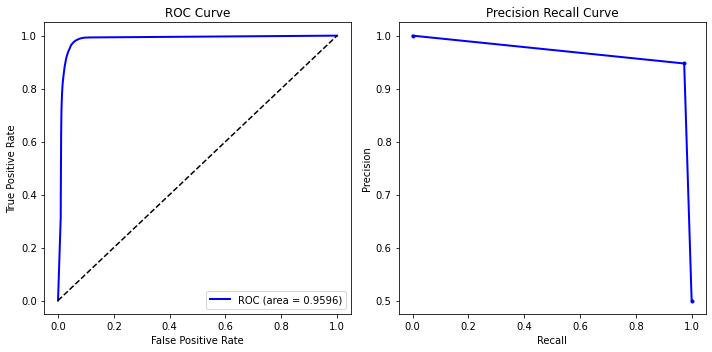

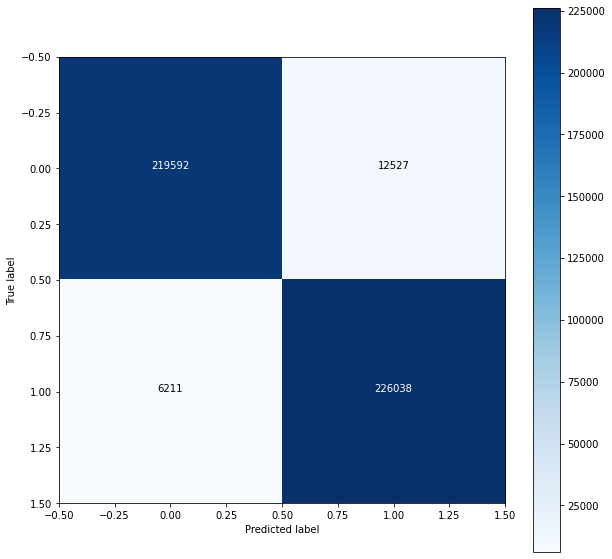

In [ ]:
# Decision Tree performance
y_pred = model_DT.predict(X_test)
y_pred_prob = model_DT.predict_proba(X_test)
y_pred_prob = y_pred_prob[:, 1]
plot_performance(y_test, y_pred, y_pred_prob)
plot_confusion(y_test, y_pred)

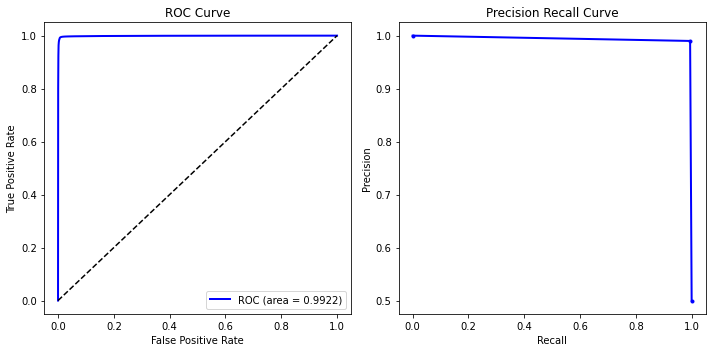

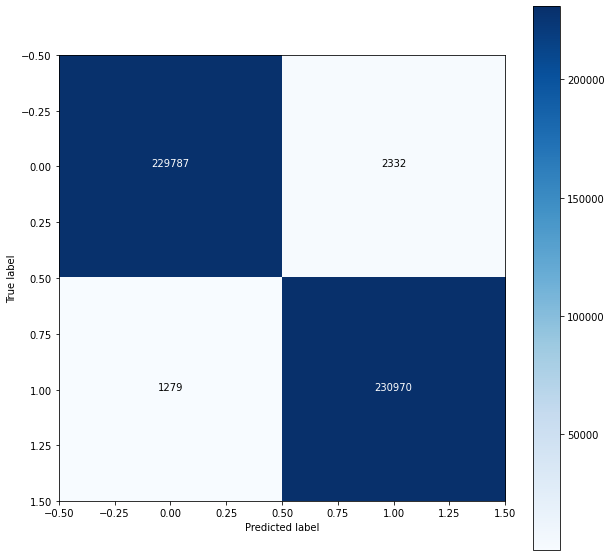

In [ ]:
# Random Forest performance  
y_pred = model_RF.predict(X_test)  
y_pred_prob = model_RF.predict_proba(X_test)  
y_pred_prob = y_pred_prob[:, 1]  
       
plot_performance(y_test, y_pred, y_pred_prob)  
plot_confusion(y_test, y_pred)

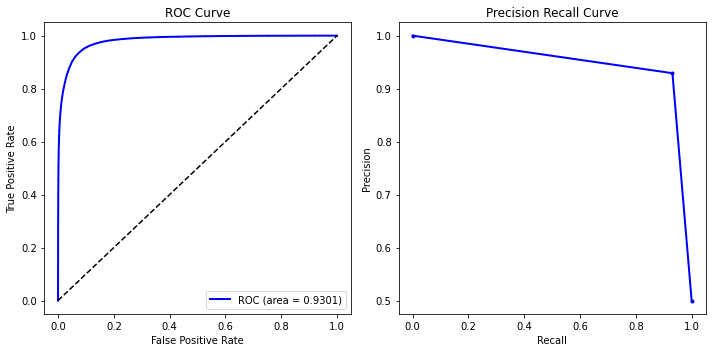

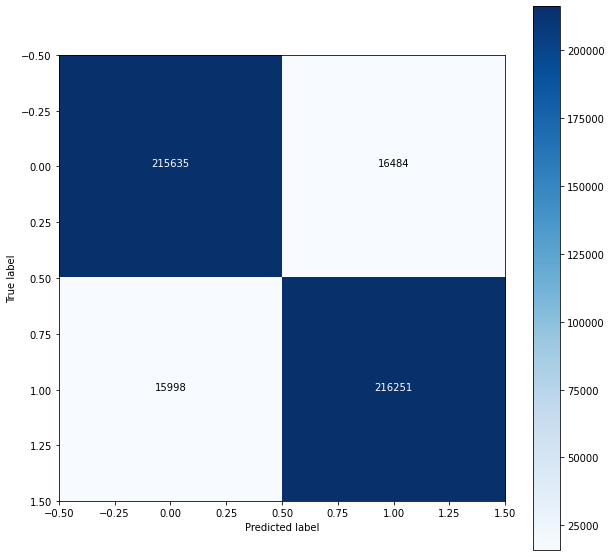

In [ ]:
# LGB performance
y_pred = model_LGB.predict(X_test) 
y_pred_prob = model_LGB.predict_proba(X_test)  
y_pred_prob = y_pred_prob[:, 1]  
    
plot_performance(y_test, y_pred, y_pred_prob) 
plot_confusion(y_test, y_pred) 

Random forests have the best performance in comparison to Decision Trees and Light Gradient Boosting models. However their training takes much longer. 

I will still prefer Random Forests for this model since the training can be sped up by using GPUs and multithreading. 

Randomized Search: Random search is a method in which random combinations of hyperparameters are selected and used to train a model. The best random hyperparameter combinations are used. we do not specify a set of possible values for every hyperparameter. Instead, we sample values from a statistical distribution for each hyperparameter. A sampling distribution is defined for every hyperparameter to do a random search. This technique allows us to control the number of attempted hyperparameter combinations.

Precision-recall curve: The Precision-Recall curve summarizes the trade-offs between the true positive rate and the positive predictive value of a predictive model using different probability thresholds. It is more appropriate for imbalanced datasets.

ROC Curve: The ROC curve summarizes the trade-offs between true positive rate and false positive rate in predictive models using different probability thresholds.

### Significant features

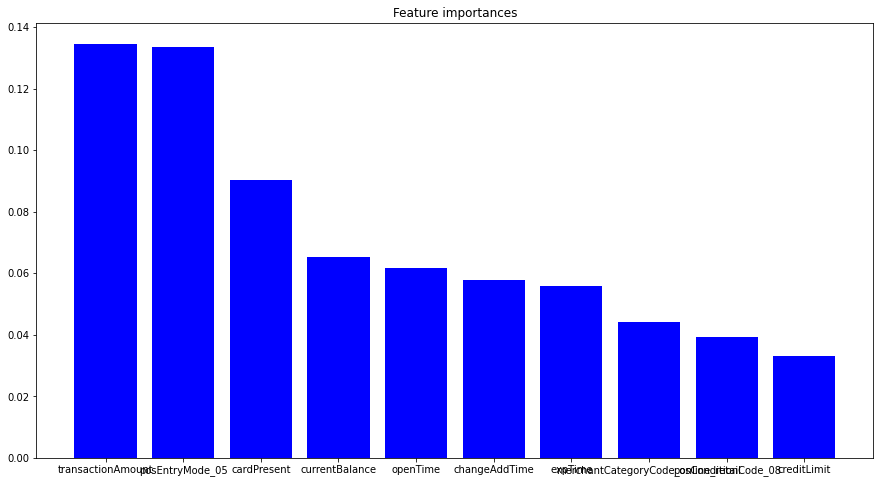

In [ ]:
importances = model_RF.feature_importances_
indices = np.argsort(importances)[::-1]

top_10= 10
top_indices = indices[:top_10]

plt.figure(figsize=(15,8))
plt.title("Feature importances")
plt.bar(range(10), importances[top_indices], align="center", color="blue")
plt.xticks(range(10), np.array(X.columns)[indices][0:10])
plt.show()

If I had more time, I would employ PCA for pre-processing, to only use components that introduce the most variance in the dataset.
I would observe the results of other boosting models like XGBoost. I would also use Artificial Neural Networks and Bayesian Belief Networks to have a more sophisticated anomaly detection model.